In [414]:
import math

import matplotlib.pyplot as plt
import numpy as np
import palettable
import pandas as pd
import pybedtools
from liftover import get_lifter
from matplotlib import patches
from matplotlib.lines import Line2D

bold_10 = palettable.cartocolors.qualitative.Bold_10.mpl_colors

from scripts import aesthetics

aesthetics.activate_paper_rcParams()

pd.set_option("display.max_columns", None)

%reload_ext autoreload
%autoreload 2

# Initial look

The goal of this notebook is just to do an initial characterization of structural variants that are in the vicinity of EWSR1 and FLI1. We'll do the actual implementation of whatever framework we decide to use elsewhere, this is just to get acquainted with the formatting and layouts of SVs.

# More on the EWSR1-FLI1 fusion

Central to this endeavor will be identifying the location of the EWSR1-FLI1 fusion. A little more on these genes specifically:

__EWSR1 (chr22:29268268-29300521)__

This gene "acts in various cellular processes, including gene expression, cell signaling, and RNA processing and transport. The protein includes an N-terminal transcriptional activation domain and a C-terminal RNA-binding domain."

EWSR1 has 17 exons and spans 32kb (656 AA). There are at least three isoforms that have been described--a full length, one with a minor (1 AA) C terminal difference, and one that lacks exon 6.

__FLI1 (chr11:128694072-128813267)__

FLI1 is a transcription factor that contains ETS DNA-binding domain. It is the portion of the fusion that is responsible for the transcriptional derangement in Ewing's. FLI1 is quite large, with 9 exons and spanning 119kb (452 AA). There are a handful of isoforms, mostly those that lack exon 4.

## So where is the fusion?

I've spent some time looking at prior studies that characterized this fusion to find the exact breakpoints, and here are a few studies that I've found:

- https://pubmed.ncbi.nlm.nih.gov/25223734/  
- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC413872/ (an old study from 1993 that used restriction enzymes to map the fusion)  
- Riaz's personal cohort.

In [2]:
gtf = pd.read_csv(
    "https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_43/gencode.v43.basic.annotation.gtf.gz",
    comment="#",
    sep="\t",
    header=None,
    names=[
        "seqname",
        "source",
        "feature",
        "start",
        "end",
        "score",
        "strand",
        "frame",
        "attribute",
    ],
)

In [3]:
# EWSR1-203 and FLI1-205 are the full length transcripts (they have tons of splice variants)
gene_gtfs = {}
gene_attrs = {"EWSR1": "EWSR1-203", "FLI1": "FLI1-205"}
for g, g_attr in gene_attrs.items():

    # extract all elements of the gene
    gene_gtfs[g] = gtf[(gtf["attribute"].str.contains(g_attr))]

In [4]:
gene_gtfs["EWSR1"]["feature"].value_counts()

exon           17
CDS            17
UTR             2
transcript      1
start_codon     1
stop_codon      1
Name: feature, dtype: int64

## Load the fusion breakpoint data

We'll be focusing on Riaz's data and the other WGS paper. These are almost certainly hg19, so we'll need to liftover.

In [5]:
riaz_data = pd.read_csv(
    "data/fusion-breakpoints/aews18b1_ewings_fusion_breakpoint_info_4_6_23.txt",
    sep="\t",
)

# some reformatting, and remove the chr prefix
riaz_fusions = riaz_data[riaz_data["Fusion"].str.contains("EWS|FLI")].copy()
riaz_fusions[["left", "right"]] = riaz_fusions["Fusion breakpoint notation"].str.split(
    "::", expand=True
)
riaz_fusions[["left", "right"]] = riaz_fusions[["left", "right"]].applymap(
    lambda bp: bp[3:]
)

# extract the SVs identified in Delattre 2014
delattre_data = pd.read_excel(
    "data/fusion-breakpoints/NIHMS628157-supplement-4.xlsx",
    sheet_name="Table S2c_SV",
    skiprows=2,
)
delattre_fusions = delattre_data[
    (delattre_data["GeneA"].str.contains("EWSR1|FLI1"))
    & (delattre_data["GeneB"].str.contains("EWSR1|FLI1"))
].copy()
delattre_fusions["left"] = (
    delattre_fusions["#chrA"].astype(str) + ":" + delattre_fusions["posA"].astype(str)
)
delattre_fusions["right"] = (
    delattre_fusions["chrB"].astype(str) + ":" + delattre_fusions["posB"].astype(str)
)

# now we do some reformatting and combine, just for the breakpoints
fusion_bps = pd.concat(
    [riaz_fusions[["left", "right"]], delattre_fusions[["left", "right"]]]
).reset_index(drop=True)

# do the liftover
hg19_to_hg38 = get_lifter("hg19", "hg38")


def liftover(bp, converter):
    contig, loc = bp.split(":")
    res = converter.query(contig, int(loc))
    return f"{res[0][0][3:]}:{res[0][1]}"


fusion_bps["left-hg38"] = fusion_bps["left"].apply(
    lambda bp: liftover(bp, hg19_to_hg38)
)
fusion_bps["right-hg38"] = fusion_bps["right"].apply(
    lambda bp: liftover(bp, hg19_to_hg38)
)

fusion_bps.head()

,left,right,left-hg38,right-hg38
0,22:29688661,11:128644198,22:29292672,11:128774303
1,22:29688506,11:128663536,22:29292517,11:128793641
2,22:29688505,11:128675650,22:29292516,11:128805755
3,22:29688473,11:128676327,22:29292484,11:128806432
4,22:29688453,11:128649624,22:29292464,11:128779729


## Mapping the fusion breakpoints

We'll plot out these genes and denote where the breakpoints happen.

In [81]:
genes = {
    "EWSR1": ["chr22", 29267009, 29301522],
    "FLI1": ["chr11", 128693072, 128814267],
}

gene_locs = pd.DataFrame.from_dict(
    genes, orient="index", columns=["chrom", "start", "end"]
)
gene_locs["gene"] = genes.keys()

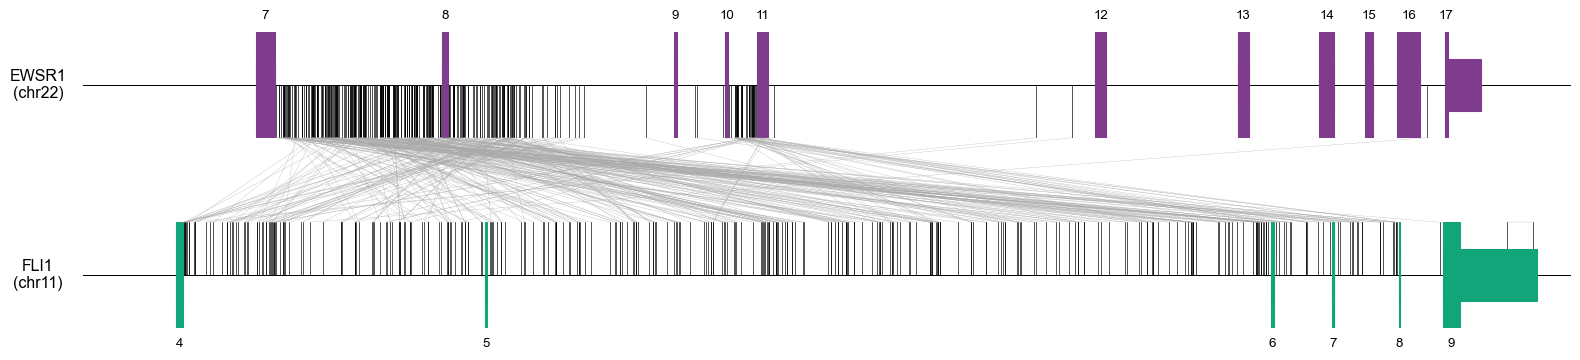

In [58]:
fig, axes = plt.subplots(2, 1, figsize=(20, 4), gridspec_kw={"hspace": 0.8})

for i, g in enumerate(["EWSR1", "FLI1"]):

    ax = axes[i]
    g_gtf = gene_gtfs[g]

    # add the exons and CDS
    exon_count = 0
    for index, row in g_gtf.iterrows():
        feature = row["feature"]

        # add coding regions and exons - coding regions are actually what
        # we care about, so they get to be larger
        if feature == "CDS":
            low, high = 0, 1
        elif feature == "exon":
            low, high = 0.25, 0.75
        elif feature != "start_codon":
            continue

        # identify start and end of region and add to plot
        start, end = row[["start", "end"]].values

        # plot only exons and CDS regions
        if feature in ["exon", "CDS"]:

            exon_patch = patches.Rectangle(
                (start, low),
                end - start,
                high - low,
                color=bold_10[i],
                fill=True,
                zorder=3,
            )
            ax.add_patch(exon_patch)

        # label the coding regions with numbers
        if feature == "CDS":
            exon_count += 1

            y = 1.1 if g == "EWSR1" else -0.1
            va = "bottom" if g == "EWSR1" else "top"

            # we don't show all the exons because fusions are localized to specific regions
            if (g == "EWSR1" and exon_count > 6) or (g == "FLI1" and exon_count > 3):
                ax.text(
                    s=f"{exon_count}",
                    x=(start + end) / 2,
                    y=y,
                    ha="center",
                    va=va,
                    fontsize=10,
                )

    # some reformatting
    ax.set_ylim([0, 1])
    ax.axhline(y=0.5, color="black", linewidth=0.75)
    aesthetics.strip_axis(ax=ax, x="label")

    contig = "chr22" if g == "EWSR1" else "chr11"
    ax.text(
        x=-0.03,
        y=0.5,
        s=g + "\n" + f"({contig})",
        transform=ax.transAxes,
        va="center",
        ha="center",
    )
    ax.set_xticklabels([])

# I know that there are no fusions outside these boundaries
axes[0].set_xlim([29285000, 29301522])
axes[1].set_xlim([128770000, 128814267])

# next we add in the breakpoints
for index, row in fusion_bps.iterrows():
    left, right = row[["left-hg38", "right-hg38"]].values

    fig_x, fig_y = [], []
    for bp in [left, right]:
        contig, loc = bp.split(":")
        loc = int(loc)

        if contig == "22":
            ax = axes[0]
            ax.plot([loc, loc], [0, 0.5], color="black", linewidth=0.5)
            data_point = [loc, 0]

        elif contig == "11":
            ax = axes[1]
            ax.plot([loc, loc], [0.5, 1], color="black", linewidth=0.5)
            data_point = [loc, 1]

        # exclude some fusions that are outside our range
        if (contig == "22" and loc < 29285000) or (contig == "11" and loc < 128770000):
            continue

        # get our figure point
        fig_point = fig.transFigure.inverted().transform(
            ax.transData.transform(data_point)
        )
        fig_x.append(fig_point[0])
        fig_y.append(fig_point[1])

    # add the connecting line
    fig.add_artist(Line2D(fig_x, fig_y, color="darkgrey", zorder=1, linewidth=0.2))

fig.savefig("images/ewsr1-fli1-fusion-locations.png")

So we see that there is some degree of heterogeneity, but the majority of fusions involve intronic regions between exons 7 and 8 in EWSR1 and exons 5 and 6 in FLI1. This is consistent with what's known.

# Start looking at SVs around these genes

We're essentially just going to repeat this process, just to visualize. We load both the SVs and the dosage matrix. Note that we'll use the "validation" cohort, because that increasingly looks like we'll use that for discovery.

In [8]:
svs = pd.read_csv(
    "gs://vanallen-pedsv-analysis/beds/PedSV.v1.1.validation_cohort.all_samples.wAFs.bed.gz",
    sep="\t",
)
dosages = pd.read_csv(
    "gs://vanallen-pedsv-analysis/beds/PedSV.v1.1.validation_cohort.analysis_samples.wAFs.allele_dosages.bed.gz",
    sep="\t",
    index_col=False,
)

/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (11,12,19,20,21,23,25,27,31,32,33,34,48,49,63,64,82,83,89,98,99,113,114,132,133,138,147,148,162,163,181,182,187,196,197,211,212,230,231,245,246,260,261,279,280,285,294,295,309,310,328,329,336,345,346,351,360,361,375,376,381,390,391,398,407,408,413,422,423,428,437,438,443,452,453,460,469,470,475,484,485,490,499,500,505,514,515,522,531,532,537,546,547,552,561,562,567,576,577,584,593,594,599,608,609,623,624,629,638,639,646,655,656,661,670,671,676,685,686,691,700,701,707,713,719,725,731) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [176]:
metadata = pd.read_csv(
    "gs://vanallen-pedsv-analysis/sample_info/gatk_sv_pediatric_cancers_combined_cohort_metadata_3_31_23.w_control_assignments.txt",
    sep="\t",
)

# extract out the samples prsent in the dosage matrix
ewings_samples = metadata[metadata["disease"] == "ewing"]["entity:sample_id"].to_list()
ewings_samples = sorted(set(dosages.columns) & set(ewings_samples))
control_samples = metadata[metadata["ewing_control"]]["entity:sample_id"].to_list()

# subset to cases and controls in the dosage matrix
ewings_samples = list(set(ewings_samples) & set(dosages.columns))
control_samples = list(set(control_samples) & set(dosages.columns))

len(ewings_samples), len(control_samples)

(580, 2019)

We begin by identifying structural variants that fall within our regions of interest. We only include SVs that pass quality filters (for now). We expand our search space to 1 Mb outside of these genes.

There are some small peculiarities that we should consider. Namely:
* SVs that span a region are included if any part of there region is 1 Mb away
* Complex SVs are included if any component SV is in the region


In [555]:
# get 1 Mb on either side of the gene
window_size = 1e6

expanded_gene_locs = gene_locs.copy()
expanded_gene_locs["start"] = (expanded_gene_locs["start"] - window_size / 2).astype(
    int
)
expanded_gene_locs["end"] = (expanded_gene_locs["end"] + window_size / 2).astype(int)

expanded_gene_bed = pybedtools.BedTool(
    expanded_gene_locs.to_csv(sep="\t", index=False, header=False), from_string=True
)
sv_bed = pybedtools.BedTool(
    svs[["#chrom", "start", "end", "name"]].to_csv(sep="\t", index=False, header=False),
    from_string=True,
)

svs_in_regions = sv_bed.intersect(expanded_gene_bed, wo=True)
svs_in_regions = svs_in_regions.to_dataframe()

# drop unnecessary columns
svs_in_regions = svs_in_regions.iloc[:, [0, 1, 2, 3, 7]].copy()
svs_in_regions.columns = ["chrom", "start", "end", "name", "gene"]

In [556]:
svs_in_regions.head(2)

,chrom,start,end,name,gene
0,chr11,128214384,128216760,All_20_Batches.chr11.final_cleanup_DEL_chr11_6406,FLI1
1,chr11,128214734,128214799,All_20_Batches.chr11.final_cleanup_DEL_chr11_6407,FLI1


In [557]:
svs_in_regions.shape

(198, 5)

So it looks like there's a handful of SVs in this region, although its nearly 1 Mb in size. But this was only based on `Start` and `End`. There are complex SVs that may involve more. 

Most complex SVs would have already been caught above, as most are intrachromosomal and handled nicely by GATK. This code is only for theoretical interchromosomal events, but I cover them for completeness.

In [558]:
# get all complex SVs
complex_svs = svs[(svs["svtype"] == "CPX")][
    [
        "name",
        "#chrom",
        "start",
        "end",
        "svtype",
        "CHR2",
        "CPX_INTERVALS",
        "CPX_TYPE",
        "END",
    ]
].copy()

# split each component SV--represented by CPX_INTERVALS--into their own rows
complex_svs = complex_svs.assign(
    intervals=complex_svs["CPX_INTERVALS"].str.split(",")
).explode("intervals")

# convert this data to a proper bed for intersection
complex_sv_bed = complex_svs[["name", "intervals"]].copy()
complex_sv_bed["chrom"] = complex_sv_bed["intervals"].apply(
    lambda interv: interv.split(":")[0].split("_")[-1]
)
complex_sv_bed["start"] = complex_sv_bed["intervals"].apply(
    lambda interv: interv.split(":")[-1].split("-")[0]
)
complex_sv_bed["end"] = complex_sv_bed["intervals"].apply(
    lambda interv: interv.split(":")[-1].split("-")[1]
)

# convert to a bedtool
complex_sv_bed = pybedtools.BedTool(
    complex_sv_bed[["chrom", "start", "end", "name"]].to_csv(
        sep="\t", index=False, header=False
    ),
    from_string=True,
)

# do our intersection
complex_svs_in_regions = complex_sv_bed.intersect(expanded_gene_bed, wo=True)

complex_svs_in_regions = complex_svs_in_regions.to_dataframe()

# drop unnecessary columns
if len(complex_svs_in_regions):
    complex_svs_in_regions = complex_svs_in_regions.iloc[:, [0, 1, 2, 3, 7]].copy()
    complex_svs_in_regions.columns = ["chrom", "start", "end", "name", "gene"]
else:
    complex_svs_in_regions = pd.DataFrame(
        columns=["chrom", "start", "end", "name", "gene"]
    )

In [559]:
complex_svs_in_regions

,chrom,start,end,name,gene
0,chr22,29729402,29729577,All_20_Batches.chr5.final_cleanup_CPX_chr5_79,EWSR1


In [560]:
# the number of complex SVs recovered, and the number that were in our original simple overlap
len(set(complex_svs_in_regions["name"])), len(
    set(complex_svs_in_regions["name"]) & set(svs_in_regions["name"])
)

(1, 0)

So looks like 1 SV was missed in our initial simple overlap. It's pretty obvious why this is the case:

In [561]:
svs[svs["name"].isin(complex_svs_in_regions["name"])].head(1)

,#chrom,start,end,name,svtype,AC,AF,ALGORITHMS,AN,BOTHSIDES_SUPPORT,CHR2,CPX_INTERVALS,CPX_TYPE,END,END2,EVIDENCE,HIGH_SR_BACKGROUND,PCRMINUS_NCR,PESR_GT_OVERDISPERSION,PREDICTED_BREAKEND_EXONIC,PREDICTED_COPY_GAIN,PREDICTED_DUP_PARTIAL,PREDICTED_INTERGENIC,PREDICTED_INTRAGENIC_EXON_DUP,PREDICTED_INTRONIC,PREDICTED_INV_SPAN,PREDICTED_LOF,PREDICTED_MSV_EXON_OVERLAP,PREDICTED_NEAREST_TSS,PREDICTED_NONCODING_BREAKPOINT,PREDICTED_NONCODING_SPAN,PREDICTED_PARTIAL_EXON_DUP,PREDICTED_PROMOTER,PREDICTED_TSS_DUP,PREDICTED_UTR,SOURCE,STRANDS,SVLEN,SVTYPE,UNRESOLVED_TYPE,N_BI_GENOS,N_HOMREF,N_HET,N_HOMALT,FREQ_HOMREF,FREQ_HET,FREQ_HOMALT,CN_NUMBER,CN_COUNT,CN_FREQ,CN_NONREF_COUNT,CN_NONREF_FREQ,MALE_AN,MALE_AC,MALE_AF,MALE_N_BI_GENOS,MALE_N_HOMREF,MALE_N_HET,MALE_N_HOMALT,MALE_FREQ_HOMREF,MALE_FREQ_HET,MALE_FREQ_HOMALT,MALE_CN_NUMBER,MALE_CN_COUNT,MALE_CN_FREQ,MALE_CN_NONREF_COUNT,MALE_CN_NONREF_FREQ,MALE_N_HEMIREF,MALE_N_HEMIALT,MALE_FREQ_HEMIREF,MALE_FREQ_HEMIALT,FEMALE_AN,FEMALE_AC,FEMALE_AF,FEMALE_N_BI_GENOS,FEMALE_N_HOMREF,FEMALE_N_HET,FEMALE_N_HOMALT,FEMALE_FREQ_HOMREF,FEMALE_FREQ_HET,FEMALE_FREQ_HOMALT,FEMALE_CN_NUMBER,FEMALE_CN_COUNT,FEMALE_CN_FREQ,FEMALE_CN_NONREF_COUNT,FEMALE_CN_NONREF_FREQ,POPMAX_AF,AFR_AN,AFR_AC,AFR_AF,AFR_N_BI_GENOS,AFR_N_HOMREF,AFR_N_HET,AFR_N_HOMALT,AFR_FREQ_HOMREF,AFR_FREQ_HET,AFR_FREQ_HOMALT,AFR_CN_NUMBER,AFR_CN_COUNT,AFR_CN_FREQ,AFR_CN_NONREF_COUNT,AFR_CN_NONREF_FREQ,AFR_MALE_AN,AFR_MALE_AC,AFR_MALE_AF,AFR_MALE_N_BI_GENOS,AFR_MALE_N_HOMREF,AFR_MALE_N_HET,AFR_MALE_N_HOMALT,AFR_MALE_FREQ_HOMREF,AFR_MALE_FREQ_HET,AFR_MALE_FREQ_HOMALT,AFR_MALE_CN_NUMBER,AFR_MALE_CN_COUNT,AFR_MALE_CN_FREQ,AFR_MALE_CN_NONREF_COUNT,AFR_MALE_CN_NONREF_FREQ,AFR_MALE_N_HEMIREF,AFR_MALE_N_HEMIALT,AFR_MALE_FREQ_HEMIREF,AFR_MALE_FREQ_HEMIALT,AFR_FEMALE_AN,AFR_FEMALE_AC,AFR_FEMALE_AF,AFR_FEMALE_N_BI_GENOS,AFR_FEMALE_N_HOMREF,AFR_FEMALE_N_HET,AFR_FEMALE_N_HOMALT,AFR_FEMALE_FREQ_HOMREF,AFR_FEMALE_FREQ_HET,AFR_FEMALE_FREQ_HOMALT,AFR_FEMALE_CN_NUMBER,AFR_FEMALE_CN_COUNT,AFR_FEMALE_CN_FREQ,AFR_FEMALE_CN_NONREF_COUNT,AFR_FEMALE_CN_NONREF_FREQ,AMR_AN,AMR_AC,AMR_AF,AMR_N_BI_GENOS,AMR_N_HOMREF,AMR_N_HET,AMR_N_HOMALT,AMR_FREQ_HOMREF,AMR_FREQ_HET,AMR_FREQ_HOMALT,AMR_CN_NUMBER,AMR_CN_COUNT,AMR_CN_FREQ,AMR_CN_NONREF_COUNT,AMR_CN_NONREF_FREQ,AMR_MALE_AN,AMR_MALE_AC,AMR_MALE_AF,AMR_MALE_N_BI_GENOS,AMR_MALE_N_HOMREF,AMR_MALE_N_HET,AMR_MALE_N_HOMALT,AMR_MALE_FREQ_HOMREF,AMR_MALE_FREQ_HET,AMR_MALE_FREQ_HOMALT,AMR_MALE_CN_NUMBER,AMR_MALE_CN_COUNT,AMR_MALE_CN_FREQ,AMR_MALE_CN_NONREF_COUNT,AMR_MALE_CN_NONREF_FREQ,AMR_MALE_N_HEMIREF,AMR_MALE_N_HEMIALT,AMR_MALE_FREQ_HEMIREF,AMR_MALE_FREQ_HEMIALT,AMR_FEMALE_AN,AMR_FEMALE_AC,AMR_FEMALE_AF,AMR_FEMALE_N_BI_GENOS,AMR_FEMALE_N_HOMREF,AMR_FEMALE_N_HET,AMR_FEMALE_N_HOMALT,AMR_FEMALE_FREQ_HOMREF,AMR_FEMALE_FREQ_HET,AMR_FEMALE_FREQ_HOMALT,AMR_FEMALE_CN_NUMBER,AMR_FEMALE_CN_COUNT,AMR_FEMALE_CN_FREQ,AMR_FEMALE_CN_NONREF_COUNT,AMR_FEMALE_CN_NONREF_FREQ,EAS_AN,EAS_AC,EAS_AF,EAS_N_BI_GENOS,EAS_N_HOMREF,EAS_N_HET,EAS_N_HOMALT,EAS_FREQ_HOMREF,EAS_FREQ_HET,EAS_FREQ_HOMALT,EAS_CN_NUMBER,EAS_CN_COUNT,EAS_CN_FREQ,EAS_CN_NONREF_COUNT,EAS_CN_NONREF_FREQ,EAS_MALE_AN,EAS_MALE_AC,EAS_MALE_AF,EAS_MALE_N_BI_GENOS,EAS_MALE_N_HOMREF,EAS_MALE_N_HET,EAS_MALE_N_HOMALT,EAS_MALE_FREQ_HOMREF,EAS_MALE_FREQ_HET,EAS_MALE_FREQ_HOMALT,EAS_MALE_CN_NUMBER,EAS_MALE_CN_COUNT,EAS_MALE_CN_FREQ,EAS_MALE_CN_NONREF_COUNT,EAS_MALE_CN_NONREF_FREQ,EAS_MALE_N_HEMIREF,EAS_MALE_N_HEMIALT,EAS_MALE_FREQ_HEMIREF,EAS_MALE_FREQ_HEMIALT,EAS_FEMALE_AN,EAS_FEMALE_AC,EAS_FEMALE_AF,EAS_FEMALE_N_BI_GENOS,EAS_FEMALE_N_HOMREF,EAS_FEMALE_N_HET,EAS_FEMALE_N_HOMALT,EAS_FEMALE_FREQ_HOMREF,EAS_FEMALE_FREQ_HET,EAS_FEMALE_FREQ_HOMALT,EAS_FEMALE_CN_NUMBER,EAS_FEMALE_CN_COUNT,EAS_FEMALE_CN_FREQ,EAS_FEMALE_CN_NONREF_COUNT,EAS_FEMALE_CN_NONREF_FREQ,EUR_AN,EUR_AC,EUR_AF,EUR_N_BI_GENOS,EUR_N_HOMREF,EUR_N_HET,EUR_N_HOMALT,EUR_FREQ_HOMREF,EUR_FREQ_HET,EUR_FREQ_HOMALT,EUR_CN_NUMBER,EUR_CN_COUNT,EUR_CN_FREQ,EUR_CN_NONREF_COUNT,EUR_CN_NONREF_FREQ,EUR_MALE_AN,EUR_MALE_AC,EUR_MALE_AF,EUR_MALE_

We can see why this was missed - it's a dispersed duplication where a region of chromosome 5 (?) was inserted into a region of chromosome 22.

In any case, we can now generate a (preliminary) list of SVs that are within 1 Mb of EWSR1 or FLI1.

## Subsetting to SVs in gene regions

In [562]:
# keep the gene names
svs_in_regions_names = pd.concat(
    [svs_in_regions[["name", "gene"]], complex_svs_in_regions[["name", "gene"]]]
)

In [563]:
len(svs_in_regions_names)

199

So a decent number of SVs in this dataset fall within this region. We fetch these from the original dataset now:

In [602]:
# very slow
svs_in_gene_regions = svs_in_regions_names.merge(svs, on=["name"])

# how many are PASS?
print(svs_in_gene_regions["FILTER"].value_counts())

# and how many are rare?
print("\nRare:\n", (svs_in_gene_regions["AF"] < 0.01).value_counts())

PASS                         171
UNRESOLVED                    15
HIGH_PCRMINUS_NOCALL_RATE     13
Name: FILTER, dtype: int64

Rare:
 True     164
False     35
Name: AF, dtype: int64


That's not bad. How many pass the filter, are rare, and are present in the dosage matrix?

In [603]:
# only include SVs that pass the FILTER, are rare, and are in our dosage matrix
svs_to_keep = svs_in_gene_regions[
    (
        (svs_in_gene_regions["FILTER"] == "PASS")
        & (svs_in_gene_regions["name"].isin(dosages["ID"].to_list()))
    )
].copy()

svs_to_keep['rare'] = svs_to_keep["AF"] < 0.01

svs_to_keep.shape

(155, 736)

In [604]:
svs_to_keep["svtype"].value_counts()

DEL             82
INS:ME:ALU      31
DUP             30
INS              4
INS:ME:LINE1     3
INS:ME:SVA       3
CTX              1
CPX              1
Name: svtype, dtype: int64

Text(0.5, 0, 'AF')

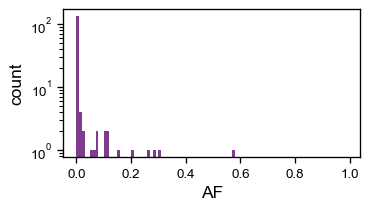

In [605]:
fig, ax = plt.subplots(1, figsize = (4, 2))
plt.hist(svs_to_keep["AF"], bins = np.arange(0, 1, 0.01))
plt.yscale('log')
plt.ylabel('count')
plt.xlabel('AF')

So there are some SVs in this region, and the vast majority are rare (unsurprisingly). We'll analyze them all together, but at some points keep rare separate.

In [606]:
# we begin by subsetting the dosage matrix down to the SVs that we care about. This double counts SVs
# that affect more than one gene.
subsetted_gene_dosages = dosages[
    dosages["ID"].isin(svs_to_keep["name"].to_list())
].reset_index(drop=True)

# we add in the information about which gene is affected (the first column is just the SV name, so we drop it)
subsetted_gene_dosages = (
    svs_to_keep[["name", "gene", "AF", "rare"]]
    .merge(subsetted_gene_dosages, right_on="ID", left_on="name")
    .iloc[1:]
)

subsetted_gene_dosages.head(2)

name  gene        AF   rare  \
1  All_20_Batches.chr11.final_cleanup_DEL_chr11_6407  FLI1  0.003384   True   
2  All_20_Batches.chr11.final_cleanup_DUP_chr11_2403  FLI1  0.304603  False   

    #chr      start        end  \
1  chr11  128214735  128214799   
2  chr11  128226922  128226985   

                                                  ID  PT_2AHXQP58  \
1  All_20_Batches.chr11.final_cleanup_DEL_chr11_6407          0.0   
2  All_20_Batches.chr11.final_cleanup_DUP_chr11_2403          0.0   

   PT_GMGNDRBJ  PT_MEC48DAY  PT_N8PKC3YS  PT_VEMC27RN  SJ051090  SJ051119  \
1          0.0          0.0          0.0          0.0       0.0       0.0   
2          1.0          1.0          1.0          1.0       0.0       1.0   

   SJ051140  SJ051197  SJ051210  SJ051231  SJ051244  SJ051246  SJ051259  \
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2       1.0       1.0       1.0       0.0       1.0       1.0       1.0   

   SJ051263  SJ051267  SJ051298  SJ051299  SJ051310  SJ051322  SJ051329  \
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2       1.0       0.0       0.0       1.0       1.0       0.0       1.0   

   SJ051336  SJ051367  SJ051390  SJ051391  SJ051392  SJ051416  SJ051439  \
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2       0.0       1.0       0.0       0.0       0.0       0.0       1.0   

   SJ051485  SJ051531  SJ051539  SJ051566  SJ051574  SJ051610  SJ051653  \
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2       0.0       1.0       0.0       0.0       0.0       1.0       1.0   

   SJ051655  SJ051662  SJ051672  SJ051679  SJ051694  SJ051705  SJ051713  \
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2       1.0       1.0       1.0       0.0       0.0       1.0       1.0   

   SJ051720  SJ051755  SJ051766  SJ051768  SJ051769  SJ051780  SJ051808  \
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2       1.0       0.0       0.0       0.0       0.0       1.0       1.0   

   SJ051810  SJ051815  SJ051835  SJ051841  SJ051844  SJ051863  SJ051867  \
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2       0.0       1.0       0.0       0.0       1.0       1.0       0.0   

   SJ051874  SJ051877  SJ051896  SJ051921  SJ051931  SJ051939  SJ051953  \
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2       0.0       1.0       0.0       2.0       0.0       0.0       0.0   

   SJ051963  SJ051999  SJ052011  SJ052022  SJ052040  SJ052054  SJ052056  \
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2       1.0       1.0       1.0       0.0       1.0       0.0       1.0   

   SJ052067  SJ052070  SJ052109  SJ052110  SJ052137  SJ052145  SJ052155  \
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2       1.0       0.0       0.0       0.0       1.0       0.0       0.0   

   SJ052157  SJ052166  SJ052179  SJ052200  SJ052211  SJ052212  SJ052223  \
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2       1.0       0.0       0.0       0.0       1.0       1.0       1.0   

   SJ052241  SJ052257  SJ052294  SJ052309  SJ052409  SJ052457  SJ052458  \
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2       1.0       2.0       1.0       1.0       0.0       1.0       1.0   

   SJ052481  SJ052494  SJ052502  SJ052585  SJ052619  SJ052646  SJ052649  \
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2       0.0       1.0       0.0       1.0       1.0       1.0       2.0   

   SJ052658  SJ052661  SJ052678  SJ052701  SJ052705  SJ052713  SJ052755  \
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2       0.0       0.0       0.0       1.0       1.0       1.0       0.0   

   SJ052785  SJ052822  SJ052851  SJ052863  SJ052871  SJ052875  SJ052907  \
1       0.0       0.0       

Next, we devise two metrics for cases and controls--one listing the count of each SV and another listing the number of samples with an SV in the gene.

In [616]:
case_control_counts = []
case_control_samples_with_svs = []

for sample_group, label in zip(
    [ewings_samples, control_samples], ["cases", "controls"]
):

    # subset to these samples
    sample_dosages = subsetted_gene_dosages[
        ["name", "gene", "#chr", "start", "end", "AF", "rare"] + sample_group
    ]

    # first, count the SVs
    # this code groups by gene and SV ID, and counts the number of nonzero entries.
    # We also count the samples that had appropriate coverage.
    sv_counts = (
        sample_dosages.groupby(["gene", "name", "start", "end", "AF", "rare"])
        .apply(
            lambda group: pd.Series(
                (group[sample_group] > 0).sum(axis=1), name=f"{label}_counts"
            )
        )
        .reset_index()
        .drop(columns="level_6")
    )
    svs_covered = (
        sample_dosages.groupby(["gene", "name", "start", "end", "AF", "rare"])
        .apply(
            lambda group: pd.Series(
                (~group[sample_group].isna()).sum(axis=1), name=f"{label}_covered"
            )
        )
        .reset_index()
        .drop(columns="level_6")
    )

    case_control_counts += [sv_counts, svs_covered]

    # now count the number of samples with at least one SV around each gene.
    # we groupby gene, then determine whether each sample has an SV in that gene, then
    # count these samples up per gene
    num_samples_with_svs = (
        sample_dosages.groupby(["gene"])
        .apply(lambda group: (group[sample_group] > 0).any(axis=0))
        .sum(axis=1)
    )
    
    num_samples_with_svs.name = label + ' all'
    case_control_samples_with_svs.append(num_samples_with_svs)
    
    num_samples_with_svs_rare = (
        sample_dosages.query('rare == True').groupby(["gene"])
        .apply(lambda group: (group[sample_group] > 0).any(axis=0))
        .sum(axis=1)
    )
    
    num_samples_with_svs_rare.name = label + ' rare'
    case_control_samples_with_svs.append(num_samples_with_svs_rare)

# merge
case_control_sv_counts = case_control_counts[0]
for df in case_control_counts[1:]:
    case_control_sv_counts = case_control_sv_counts.merge(df)

case_control_sv_counts["cases_perc"] = (
    case_control_sv_counts["cases_counts"] / case_control_sv_counts["cases_covered"]
)
case_control_sv_counts["controls_perc"] = (
    case_control_sv_counts["controls_counts"]
    / case_control_sv_counts["controls_covered"]
)

# and total up the sample counts
case_control_sample_counts = pd.DataFrame(case_control_samples_with_svs).T

In [674]:
(sample_dosages[control_samples] > 1).sum(axis = 1)

1        0
2      189
3        0
4        0
5        0
      ... 
150      5
151      0
152      0
153      0
154      0
Length: 154, dtype: int64

What does the percentage breakdown look like?

In [619]:
case_control_sample_counts / np.array([len(ewings_samples)] * 2 + [len(control_samples)] * 2)

,cases all,cases rare,controls all,controls rare
gene,,,,
EWSR1,0.994828,0.072414,0.998019,0.102526
FLI1,0.960345,0.043103,0.958395,0.069341


Interesting--unless I've made a mistake, the controls have more rare SVs around these genes than controls.

Any smoking guns in terms of SVs?

In [635]:
freq_diff = case_control_sv_counts["cases_perc"] - (
    case_control_sv_counts["controls_perc"]
)

case_control_sv_counts.iloc[freq_diff.sort_values(ascending=False).index]

,gene,name,start,end,AF,rare,cases_counts,cases_covered,controls_counts,controls_covered,cases_perc,controls_perc,midpoint
109,FLI1,All_20_Batches.chr11.final_cleanup_DEL_chr11_6436,128930551,128930727,0.209161,False,260,580,769,2019,0.448276,0.380882,128930551.0
120,FLI1,All_20_Batches.chr11.final_cleanup_DUP_chr11_2403,128226922,128226985,0.304603,False,357,580,1134,2019,0.615517,0.561664,128226922.0
125,FLI1,All_20_Batches.chr11.final_cleanup_DUP_chr11_2410,128930541,128930890,0.076277,False,86,562,219,1981,0.153025,0.110550,128930541.0
101,FLI1,All_20_Batches.chr11.final_cleanup_DEL_chr11_6427,128812821,128813515,0.289824,False,294,580,972,2019,0.506897,0.481426,128812821.0
126,FLI1,All_20_Batches.chr11.final_cleanup_DUP_chr11_2411,128930541,128930680,0.011284,False,18,544,24,1911,0.033088,0.012559,128930541.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,FLI1,All_20_Batches.chr11.final_cleanup_DUP_chr11_2417,129143632,129145383,0.103791,False,122,580,464,2019,0.210345,0.229817,129143632.0
38,EWSR1,All_20_Batches.chr22.final_cleanup_DEL_chr22_1136,29584176,29584657,0.009138,True,3,580,51,2019,0.005172,0.025260,29584176.0
46,EWSR1,All_20_Batches.chr22.final_cleanup_DEL_chr22_1146,29767441,29769676,0.063515,False,66,580,273,2019,0.113793,0.135215,29767441.0
56,EWSR1,All_20_Batches.chr22.final_cleanup_DUP_chr22_557,29410573,29410660,0.115411,False,114,580,592,2019,0.196552,0.293214,29410573.0


I find that somewhat surprising... there are several instances where the number of SVs in a gene is dramatically different between cases and controls, but it seems to favor the controls. What could be the reason for this, ancestry? Artifact?

## Where do these fall relative to gene regions?

Presumably, the closer they are to the gene, the more we expect them to matter. We'll just map them out on the gene locuses (I like to visualize first).

This is a little hamfisted, but we'll split by common SVs and then just rare.

/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: FixedFormatter should only be used together with FixedLocator


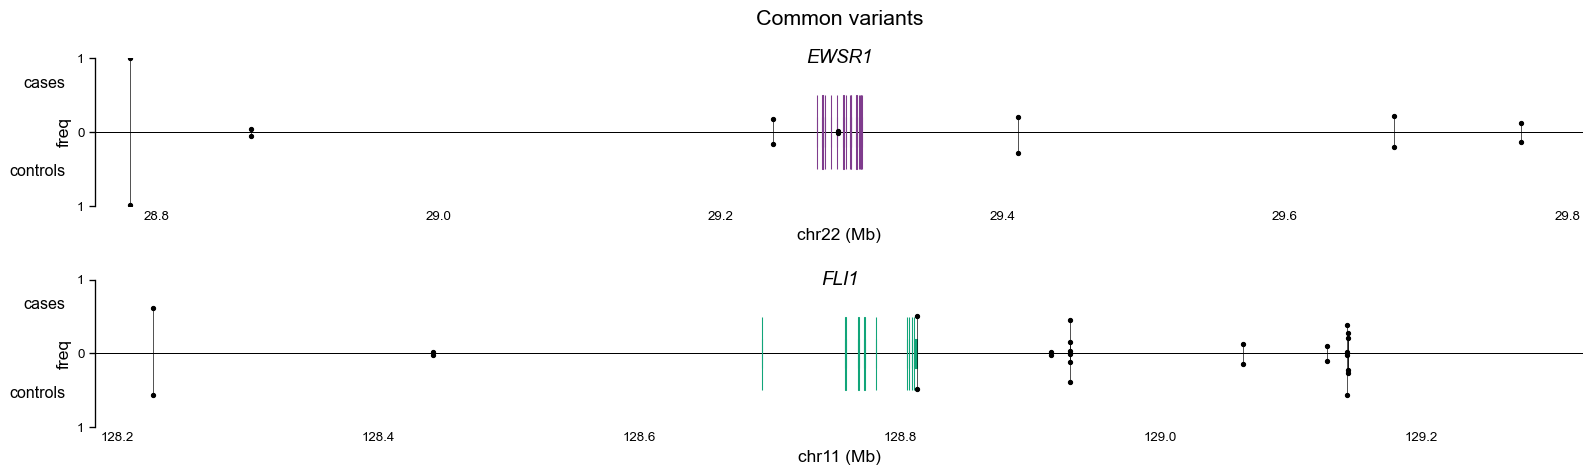

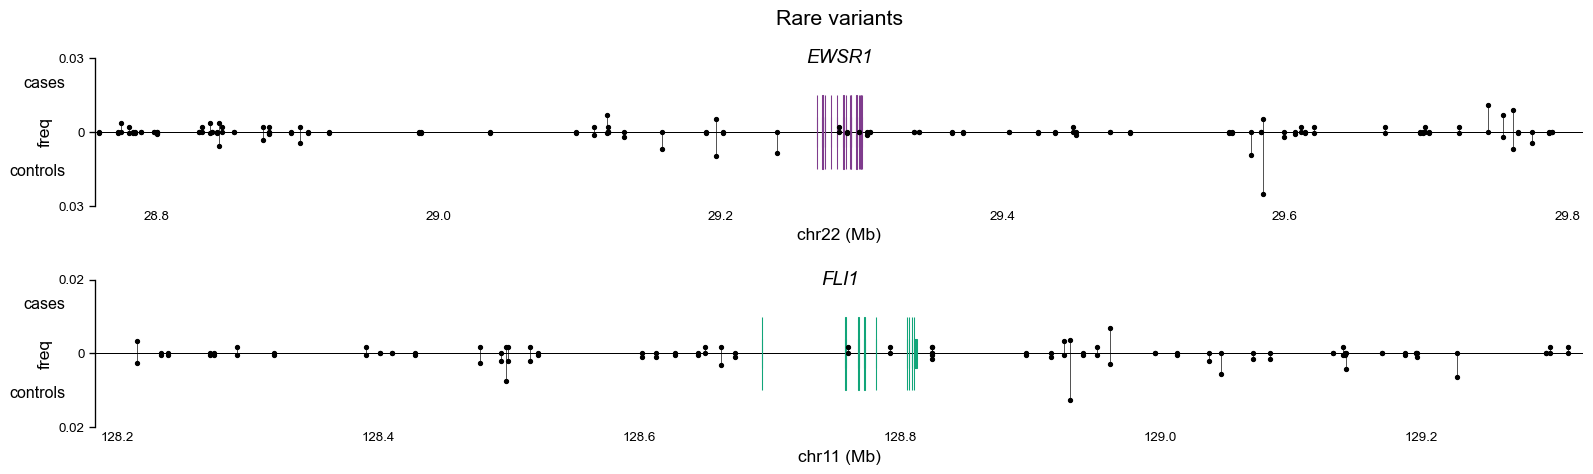

In [721]:
for plot in ['common', 'rare']:

    fig, axes = plt.subplots(
        len(expanded_gene_locs),
        1,
        figsize=(20, 2.5 * len(expanded_gene_locs)),
        gridspec_kw={"hspace": 0.5},
    )

    for i, g in enumerate(expanded_gene_locs["gene"]):

        ax = axes[i]
        g_gtf = gene_gtfs[g]

        # add the exons and CDS
        for index, row in g_gtf.iterrows():
            feature = row["feature"]

            # add coding regions and exons - coding regions are actually what
            # we care about, so they get to be larger
            if feature == "CDS":
                low, high = 0.25, 0.75
            elif feature == "exon":
                low, high = 0.4, 0.6
            elif feature != "start_codon":
                continue

            # identify start and end of region and add to plot
            start, end = row[["start", "end"]].values

            # plot only exons and CDS regions
            if feature in ["exon", "CDS"]:

                exon_patch = patches.Rectangle(
                    (start, low),
                    end - start,
                    high - low,
                    color=bold_10[i],
                    fill=True,
                    zorder=3,
                )
                ax.add_patch(exon_patch)

        # some reformatting
        ax.set_ylim([0, 1])
        ax.axhline(y=0.5, color="black", linewidth=0.75)
        aesthetics.strip_axis(ax=ax, x="label", y="ignore")

        contig = expanded_gene_locs.loc[g, "chrom"]
        ax.text(
            x=0.5,
            y=1,
            s=g,
            transform=ax.transAxes,
            va="center",
            ha="center",
            fontsize = 14,
            fontstyle = 'italic'
        )

        # plot the range of interest
        ax.set_xlim(expanded_gene_locs.loc[g, ["start", "end"]].values + np.array([-10000, 10000]))
        ax.spines['bottom'].set_bounds(expanded_gene_locs.loc[g, ["start", "end"]].values)
        
        # add labels 
        ax.text(s = 'cases', x = -0.02, y = 0.8, transform=ax.transAxes, ha = 'right')
        ax.text(s = 'controls', x = -0.02, y = 0.2, transform=ax.transAxes, ha = 'right')
        
        # switch to Mb
        ax.set_xticklabels(ax.get_xticks() / 1e6)
        ax.set_xlabel(f'{contig} (Mb)')

    # next we add in the SVs. First subset to the SVs in question
    if plot == 'common':
        plot_svs = case_control_sv_counts.query('rare == False').copy()
    elif plot == 'rare':
        plot_svs = case_control_sv_counts.query('rare == True').copy()
    
    plot_svs["midpoint"] = (
        plot_svs["start"] + plot_svs["start"]
    ) / 2
    for i, gene in enumerate(expanded_gene_locs["gene"]):

        ax = axes[i]
        gene_data = plot_svs[plot_svs["gene"] == gene]

        # get the max frequency
        max_freq = gene_data[["cases_perc", "controls_perc"]].max().max()
        
        if plot == 'common':
            rounded_max = 1
        if plot == 'rare':
            rounded_max = math.ceil(max_freq * 100) / 100

        # its much easier to plot everything at once with plt.stem, but that function sucks
        # we scale the frequency to fill the plot
        case_y = ((gene_data["cases_perc"]) / rounded_max) * 0.5
        control_y = ((gene_data["controls_perc"]) / rounded_max) * 0.5

        # add the points
        ax.scatter(x=gene_data["midpoint"], y=0.5 + case_y, color="black", s=10, zorder = 3)
        ax.scatter(x=gene_data["midpoint"], y=0.5 - control_y, color="black", s=10, zorder = 3)

        # add the lollipop lines
        for loc, case, control in zip(gene_data["midpoint"], case_y, control_y):
            ax.plot([loc, loc], [0.5 + case, 0.5 - control], color="black", linewidth=0.5, zorder = 3)

        ax.set_yticks([0, 0.5, 1])
        ax.set_yticklabels([rounded_max, 0, rounded_max])
        ax.set_ylabel("freq")
        
    axes[0].text(s = plot.capitalize() + ' variants', x = 0.5, y = 1.2, transform = axes[0].transAxes, 
                 ha = 'center', va = 'bottom', fontsize = 16)
    
    fig.savefig(f'images/{plot}.png')